# Download dataset

## method1. upload dataset manually (slow)

In [2]:
# from google.colab import files
# uploaded = files.upload()

## method 2. faster way using kaggle command ( please check https://www.kaggle.com/general/74235)

In [3]:
#1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

#2. Click on Create New API Token - It will download kaggle.json file on your machine.

#3. Go to your Google Colab project file and run the following commands:
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

## You can put the dataset in Google Drive by running the following commands

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/MyDrive"

In [5]:
# unzip dataset
# !kaggle competitions download -c computer-vision-hw4-2023
# !unzip computer-vision-hw4-2023.zip

In [6]:
!nvidia-smi

Sun Dec 10 17:43:38 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.17                 Driver Version: 546.17       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:09:00.0  On |                  N/A |
| 78%   41C    P5              33W / 170W |    963MiB / 12288MiB |     11%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Init and Utility

In [7]:
# !pip install scikit-image

In [1]:
import warnings
import os
from pathlib import Path
from datetime import datetime
from tqdm import tqdm

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from IPython import display
from skimage import util
from skimage.transform import ProjectiveTransform, warp
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import random
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as tf
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
import torchvision.models as models
import cv2
import shutil
import warnings

In [2]:
# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
ROOT_DIR = Path('./ccpd6000/') # the root directory of the dataset

In [3]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img

def draw_plate(img, kpts):
    '''Perspective tranform and draw the plate indicated by kpts to a 96x30 rectangle.
    Args:
        img: (PIL.Image) will be modified
        kpts: (FloatTensor) keypoints in xy format, sized [8,]
    Return:
        img: (PIL.Image) modified image
    Reference: http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_geometric.html
    '''
    src = np.float32([[96, 30], [0, 30], [0, 0], [96, 0]])
    dst = kpts.view(4, 2).numpy()
    dst = dst * np.float32(img.size)

    transform = ProjectiveTransform()
    transform.estimate(src, dst)
    with warnings.catch_warnings(): # surpress skimage warning
        warnings.simplefilter("ignore")
        warped = warp(np.array(img), transform, output_shape=(30, 96))
        warped = util.img_as_ubyte(warped)
    plate = Image.fromarray(warped)
    img.paste(plate)
    return img

# Training Data

3000
torch.Size([3, 320, 192])
tensor(1.)
torch.Size([8])


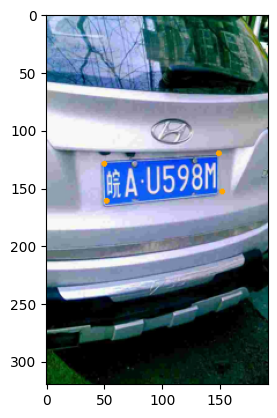

In [4]:
class TrainData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = Path(img_dir)
        self.img_paths = self.img_dir.glob('*.jpg')
        self.img_paths = sorted(list(self.img_paths))

    def __len__(self):
        '''Return the number of sample
        '''
        return len(self.anns)

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of
                bottom-right, bottom-left, top-left, top-right corners.
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''
        img_path = self.img_paths[idx]

        # load image
        img = Image.open(img_path)
        W, H = img.size
        img = img.convert('RGB')
        # img = img.resize((192, 320))
        img = img.resize((192, 320))
        img = tf.to_tensor(img)

        # parse annotation
        kpt = self.anns[idx]
        kpt = list(kpt.values())[1:9]
        kpt = torch.tensor(kpt) # [8,]
        kpt = kpt.view(4, 2) # [4, 2]
        kpt = kpt / torch.FloatTensor([W, H])
        kpt = kpt.view(-1) # [8,]

        return img, kpt


# Do some checking and visualization
data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
print(len(data))    # should be 3000

img, kpt = data[-1] # get a sample
print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = tf.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()

# Network

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models


class CustomResNet18(nn.Module):
    def __init__(self, num_classes=512):
        super(CustomResNet18, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet18.children())[:-1])
        self.fc = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class CustomResNet50(nn.Module):
  def __init__(self, num_classes = 512):
    super(CustomResNet50, self).__init__()
    resnet50 = models.resnet50(pretrained=True)
    self.features = nn.Sequential(*list(resnet50.children())[:-1])
    self.fc = nn.Linear(2048, 512)

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)

            )
    def forward(self, x):
      residual = x

      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)

      out = self.conv2(out)
      out = self.bn2(out)

      out += self.shortcut(residual)
      out = self.relu(out)

      return out
class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)
        '''
        super().__init__() # necessary

        # TODO : add more layers to achieve better performance
        # self.features =
        # TODO : add ouput layer to predict position
        # Note : the orginal kpts of data have been normalized (0-1)
        # self.regression =
        # TODO : add more layers to achieve better performance
        self.features = nn.Sequential(
            CustomResNet50()
            # CustomResNet18()
            # ConvBlock(3,8),
            # ResidualBlock(8, 8),
            # ConvBlock(8,16),
            # ConvBlock(9,18),
        )
        # TODO : add ouput layer to predict position
        # Note : the orginal kpts of data have been normalized (0-1)
        self.regression = nn.Sequential(
            nn.Flatten(),
            # nn.Linear((256*(input_size)//8) * (input_size//8), 512),
            # nn.Linear(6*320*192, 512),
            # nn.Linear(16*192*320, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 8)
        )

    def forward(self, img_b):
        '''Define how layers are interact, that is, the forward function.
        In this network, img_b is passed to self.features and
        the result is passed to self.regression.

        Args:
            img_b: (torch.FloatTensor) input images (mini-batch), shaped [N, 3, H, W]
        Return:
            kpt_b: (torch.FloatTensor) the predictions (mini-batch), shaped [N, 8]
        '''
        features = self.features(img_b)
        kpt_b = self.regression(features)
        return kpt_b


# Do some checking
loader = DataLoader(data, batch_size=32) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]

# Do a forwarding
device = 'cuda'     # the computing device, 'cuda' or 'cpu'
model = Net().to(device) # instantiate network and move it to device
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)
loss = criterion(pred_b, kpt_b)
print(loss)

torch.Size([32, 3, 320, 192])
torch.Size([32, 8])


c:\Users\MA\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MA\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor(0.4856, device='cuda:0', grad_fn=<MeanBackward0>)


In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=512):
        super(CustomResNet18, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet18.children())[:-1])
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class CustomResNet50(nn.Module):
  def __init__(self, num_classes = 512):
    super(CustomResNet50, self).__init__()
    resnet50 = models.resnet50(pretrained=True)
    self.features = nn.Sequential(*list(resnet50.children())[:-1])
    self.fc = nn.Linear(2048, 512)

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)

            )
    def forward(self, x):
      residual = x

      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)

      out = self.conv2(out)
      out = self.bn2(out)

      out += self.shortcut(residual)
      out = self.relu(out)

      return out
class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)
        '''
        super().__init__() # necessary

        # TODO : add more layers to achieve better performance
        # self.features =
        # TODO : add ouput layer to predict position
        # Note : the orginal kpts of data have been normalized (0-1)
        # self.regression =
        # TODO : add more layers to achieve better performance
        self.features = nn.Sequential(
            CustomResNet50()
            # CustomResNet18()
            # ConvBlock(3,8),
            # ResidualBlock(8, 8),
            # ConvBlock(8,16),
            # ConvBlock(9,18),
        )
        # TODO : add ouput layer to predict position
        # Note : the orginal kpts of data have been normalized (0-1)
        self.regression = nn.Sequential(
            nn.Flatten(),
            # nn.Linear((256*(input_size)//8) * (input_size//8), 512),
            # nn.Linear(6*320*192, 512),
            # nn.Linear(16*192*320, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 8)
        )

    def forward(self, img_b):
        '''Define how layers are interact, that is, the forward function.
        In this network, img_b is passed to self.features and
        the result is passed to self.regression.

        Args:
            img_b: (torch.FloatTensor) input images (mini-batch), shaped [N, 3, H, W]
        Return:
            kpt_b: (torch.FloatTensor) the predictions (mini-batch), shaped [N, 8]
        '''
        features = self.features(img_b)
        kpt_b = self.regression(features)
        return kpt_b


# Do some checking
loader = DataLoader(data, batch_size=32) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]

# Do a forwarding
device = 'cuda'     # the computing device, 'cuda' or 'cpu'
model = Net().to(device) # instantiate network and move it to device
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)
print(pred_b)
loss = criterion(pred_b, kpt_b)
print(loss)

torch.Size([32, 3, 320, 192])
torch.Size([32, 8])
tensor([[-0.1004,  0.0959, -0.0698,  0.0464, -0.0629, -0.0667,  0.0020, -0.0235],
        [-0.1318,  0.0782, -0.0678,  0.0648, -0.0275, -0.0618,  0.0265, -0.0175],
        [-0.0808,  0.0589, -0.0453,  0.0429, -0.0485, -0.0378,  0.0297, -0.0309],
        [-0.1261,  0.0408, -0.0666,  0.0123, -0.0049, -0.0262, -0.0017, -0.0299],
        [-0.1282,  0.0549, -0.0410,  0.0546, -0.0134, -0.0581,  0.0143,  0.0126],
        [-0.1233,  0.0863, -0.0199,  0.0331, -0.0787, -0.0416, -0.0270, -0.0271],
        [-0.1454,  0.0757, -0.0229,  0.0242, -0.0240, -0.0595, -0.0107,  0.0059],
        [-0.1505,  0.0687, -0.0075,  0.0469, -0.0235, -0.0471, -0.0173, -0.0276],
        [-0.1310,  0.1055, -0.0420,  0.0301, -0.0567, -0.0666, -0.0003, -0.0275],
        [-0.1183,  0.1045, -0.0533,  0.0619, -0.0453, -0.0299, -0.0442, -0.0142],
        [-0.1108,  0.0941, -0.0557,  0.0509, -0.0051, -0.0573, -0.0343,  0.0323],
        [-0.1098,  0.0594, -0.0502,  0.0113, -0.

# Training

c:\Users\MA\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MA\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


lr: 0.0008
Epoch 000:
train loss: 0.08560539111495018
valid loss: 0.0651219232301963
lr: 0.0008
Epoch 001:
train loss: 0.060712050050497054
valid loss: 0.0593285576293343
lr: 0.0008
Epoch 002:
train loss: 0.06122261931498845
valid loss: 0.05800869982493551
lr: 0.0008
Epoch 003:
train loss: 0.06250296731789907
valid loss: 0.06075447366425866
lr: 0.0008
Epoch 004:
train loss: 0.0593790773053964
valid loss: 0.0672901204149974
lr: 0.0008
Epoch 005:
train loss: 0.05924406846364339
valid loss: 0.05809185124541584
lr: 0.0008
Epoch 006:
train loss: 0.0586311632891496
valid loss: 0.059119704326516705
lr: 0.0008
Epoch 007:
train loss: 0.05832073012987773
valid loss: 0.057318519212697684
lr: 0.0008
Epoch 008:
train loss: 0.0590965723991394
valid loss: 0.06020524117507433
lr: 0.0008
Epoch 009:
train loss: 0.059046892474095024
valid loss: 0.062277464098051974
lr: 0.0008
Epoch 010:
train loss: 0.0593203770617644
valid loss: 0.05719013335673433
lr: 0.0008
Epoch 011:
train loss: 0.05820416202147802
va

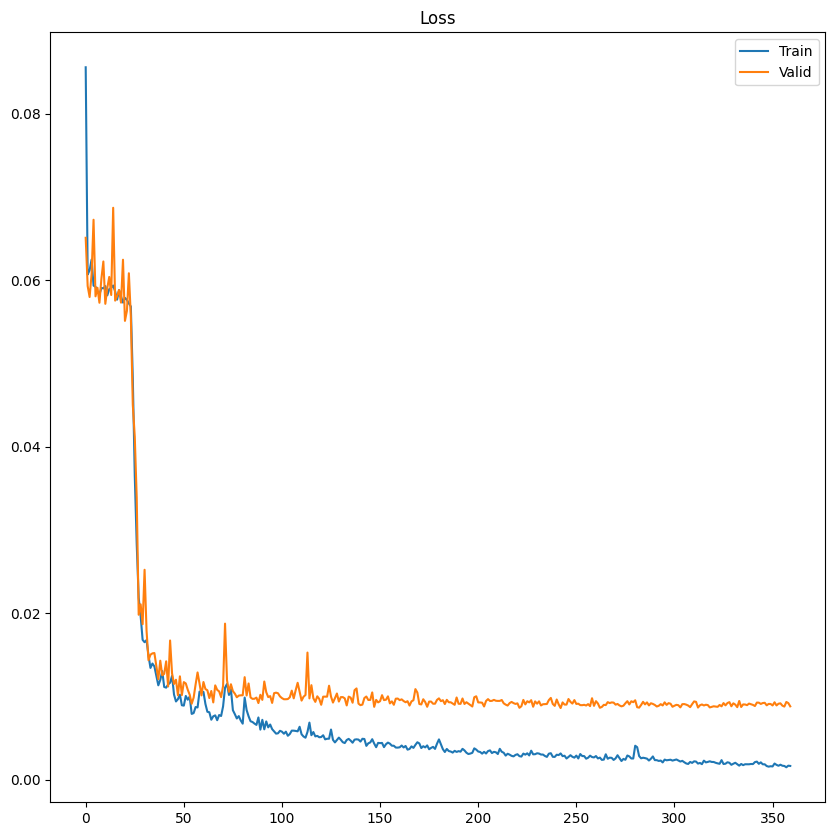

In [9]:
class Trainer:
    def __init__(self, log_dir):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Make the corresponding dataloaders
        data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))

        self.train_loader = DataLoader(self.train_set, 32, shuffle=True, ) #這邊我有把batch_size改成32 -原本是10
        self.valid_loader = DataLoader(self.valid_set, 32, shuffle=False, ) #我的電腦使用num_workers=4會卡住

        # model, loss function, optimizer
        self.device = 'cuda'
        self.model = Net().to(self.device)

        self.criterion = nn.L1Loss()
        # print(self.model)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=8e-4)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.95, patience=8, verbose=True)
        self.max_epoch = 360   #TODO define your training epochs

    def run(self):
        training_result_dir = self.log_dir / 'training_result'
        training_result_dir.mkdir(parents=True)
        metrics = {'train_loss': [], 'valid_loss': []}

        for self.epoch in range(self.max_epoch): # epochs
            train_loss = self.train() # train 1 epoch
            valid_loss = self.valid() # valid 1 epoch
            print('lr:',get_lr(self.optimizer))
            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)
            # Save the parameters(weights) of the model to disk
            if torch.tensor(metrics['valid_loss']).argmin() == self.epoch:
                torch.save(self.model.state_dict(), str(training_result_dir / 'model.pth'))

        # Plot the loss curve against epoch
        fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
        ax.set_title('Loss')
        ax.plot(range(self.epoch + 1), metrics['train_loss'], label='Train')
        ax.plot(range(self.epoch + 1), metrics['valid_loss'], label='Valid')
        ax.legend()
        plt.show()
        fig.savefig(str(training_result_dir / 'metrics.jpg'))
        plt.close()

    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''
        # self.model.train()
        loss_steps = []
        mse_steps = []
        total_batches = len(self.train_loader)
        # print(total_batches)
        for batch_idx , (img_b, kpt_b) in enumerate(self.train_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            self.optimizer.zero_grad()
            # enhanced_image = img_b.clone()
            # print(img_b.shape)
            img_b[:, 2, :, :] *= 1.5  # 增強藍色通道 這邊想嘗試增強顏色資訊並嘗試
            img_b[:, 0, :, :] *= 0.8  # 減弱紅色通道
            # print(img_b.shape)
            # print(img_b.shape)
            pred_b = self.model(img_b)

            # TODO
            # step 1 caculate the loss
            loss = self.criterion(pred_b, kpt_b)
            # step 2 back propagation
            loss.backward()
            # step 3 update parameters using optimizer
            self.optimizer.step()
            # print(loss.item())
            # print(f"Batch {batch_idx + 1}/{total_batches}, Loss: {loss.item()}")
            loss_steps.append(loss.detach().item())
            
            torch.cuda.empty_cache() #刪除CUDA緩存
        avg_loss = sum(loss_steps) / len(loss_steps)
        # print(avg_loss)
        self.scheduler.step(avg_loss) #加入scheduler
        return avg_loss

    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''
        self.model.eval()
        loss_steps = []
        mse_steps = []

        for img_b, kpt_b in iter(self.valid_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            pred_b = self.model(img_b)
            loss = self.criterion(pred_b, kpt_b)
            # print(loss)
            loss_steps.append(loss.detach().item())
            torch.cuda.empty_cache() #刪除CUDA緩存
        avg_loss = sum(loss_steps) / len(loss_steps)
        
        return avg_loss

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


log_dir = Path('./runs/') / f'{datetime.now():%b.%d %H-%M-%S}'
log_dir.mkdir(parents=True)
Trainer(log_dir).run()

# Testing

In [10]:
# Do testing
from pathlib import Path
from datetime import datetime
import pandas as pd
from tqdm import tqdm
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as tf

#import utils
#from utils.model import CCPDRegressor

img_size=(192, 320)
class CCPDTest:
    def __init__(self, img_dir):
        img_paths = Path(img_dir).glob('*.jpg')
        self.img_paths = sorted(list(img_paths))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)
        return img


test_set = CCPDTest('./ccpd6000/test_images')
test_loader = DataLoader(test_set, 32, shuffle=False)

device = 'cuda'
# resnet18 = models.resnet18(pretrained=True)
model = Net().to(device)
model.load_state_dict(torch.load(str(log_dir / 'training_result/model.pth')))
# model.load_state_dict(torch.load('C:/Users/MA/Desktop/計算視覺理論HW04/runs/Dec.20 07-52-25/training_result/model.pth'))
model.eval()

# 計算總參數量
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')

# 計算可訓練參數量
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Trainable parameters: {trainable_params}')


log_dir_test = Path('./testing_result') / f'{datetime.now():%b.%d %H-%M-%S}'
log_dir_test.mkdir(parents=True)
print(log_dir_test)

def test(pbar):
    model.eval()
    anns = []
    for img_b in iter(test_loader):
        # print(img_b.shape)
        img_b[:, 2, :, :] *= 1.5  # 增強藍色通道
        img_b[:, 0, :, :] *= 0.8  # 減弱紅色通道
        # print(img_b.shape)
        kpt_b = model(img_b.to(device))
        kpt_b = kpt_b.cpu()
        for img, kpt in zip(img_b, kpt_b):
            img = tf.to_pil_image(img)
            vis = draw_plate(img, kpt)
            vis = draw_kpts(vis, kpt, c='red')
            vis.save(log_dir_test / f'{pbar.n:03d}_vis.jpg')
            # Original image size: 720 * 1160
            kpt[0:-1:2] *= 720
            kpt[1::2] *= 1160
            anns.append([f'{pbar.n:04d}.jpg', *kpt.numpy().tolist()])
            pbar.update()

    return pd.DataFrame(anns)

with torch.no_grad():
    with tqdm(total=len(test_set)) as pbar:
        df_pred = test(pbar)
    df_pred.columns = ['name', 'BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y']
    df_pred.to_csv('./ccpd6000/test_pred.csv', float_format='%.5f', index=False)

c:\Users\MA\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MA\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 24823880
Trainable parameters: 24823880
testing_result\Dec.21 16-30-30


100%|██████████| 3000/3000 [01:05<00:00, 45.51it/s]


### 學習如何觀察模型每一層輸出的結果

In [79]:
import torch
import torch.nn as nn
import torchvision.models as models

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        # 提取 ResNet-50 的層
        self.resnet_layers = nn.Sequential(*list(self.resnet50.children())[:-2])

    def forward(self, x):
        resnet_output = self.resnet_layers(x)

        return resnet_output

model = MyModel()
model.eval()
def hook_fn(module, input, output):
    print(f"{module.__class__.__name__} output shape: {output.shape}")

# 將 hook 函數註冊到 ResNet-50 中間層的每一層
hook_handle = model.resnet_layers.register_forward_hook(hook_fn)

# 使用模型進行推論（例如，使用一個隨機的輸入）
input_data = torch.randn(1, 3, 224, 224)
output = model(input_data)
imag_a = output[:,0,:,:]
print(imag_a)
# 移除 hook
hook_handle.remove()


c:\Users\MA\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MA\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential output shape: torch.Size([1, 2048, 7, 7])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0786, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0444, 0.0000, 0.0000],
         [0.1842, 0.1873, 0.0411, 0.0135, 0.0868, 0.0751, 0.0000],
         [0.2651, 0.4030, 0.5505, 0.5175, 0.5500, 0.4958, 0.2968]]],
       grad_fn=<SliceBackward0>)


### 用來查看test的結果

In [10]:
import cv2
import pandas as pd
import os

# 讀取CSV檔案
df = pd.read_csv(r'ccpd6000\test_pred.csv')

# 設定圖片資料夾路徑
image_folder = r'ccpd6000\test_images'

for index, row in df.iterrows():
    # 組合完整的圖片路徑
    print(row)
    image_path = os.path.join(image_folder, row['name'])

    # 讀取圖片
    image = cv2.imread(image_path)

    # 提取框選位置資訊
    BR_x, BR_y, BL_x, BL_y, TL_x, TL_y, TR_x, TR_y = (
        int(row['BR_x']), int(row['BR_y']),
        int(row['BL_x']), int(row['BL_y']),
        int(row['TL_x']), int(row['TL_y']),
        int(row['TR_x']), int(row['TR_y'])
    )

    # 標記框選位置
    cv2.rectangle(image, (TL_x, TL_y), (BR_x, BR_y), (0, 255, 0), 2)

    # 顯示圖片
    cv2.imshow('Image with bounding box', image)
    cv2.waitKey(0)

cv2.destroyAllWindows()


name     0000.jpg
BR_x    384.63153
BR_y    604.44916
BL_x    233.91214
BL_y    563.59973
TL_x    227.00853
TL_y    509.18411
TR_x    376.62515
TR_y    547.03381
Name: 0, dtype: object
name     0001.jpg
BR_x    448.36652
BR_y    540.23877
BL_x    274.11926
BL_y    537.82788
TL_x    275.82764
TL_y    485.82297
TR_x    449.28766
TR_y    486.16663
Name: 1, dtype: object
name     0002.jpg
BR_x    457.79526
BR_y     509.3768
BL_x     346.8447
BL_y    508.61157
TL_x    350.60123
TL_y    471.65771
TR_x    459.60892
TR_y    469.10455
Name: 2, dtype: object
name     0003.jpg
BR_x     501.1384
BR_y    595.83923
BL_x    303.20676
BL_y    578.26379
TL_x    297.73807
TL_y    523.58862
TR_x    495.35513
TR_y    538.35083
Name: 3, dtype: object
name     0004.jpg
BR_x    436.01724
BR_y     584.3656
BL_x    156.61108
BL_y     593.1828
TL_x    153.65683
TL_y    522.39166
TR_x    432.87936
TR_y    511.30838
Name: 4, dtype: object
name     0005.jpg
BR_x     503.9093
BR_y    610.60852
BL_x    287.87045
BL_

KeyboardInterrupt: 

### 用來查看train的結果

In [20]:
import cv2
import pandas as pd
import os

# 讀取CSV檔案
df = pd.read_csv(r'ccpd6000\train.csv')

# 設定圖片資料夾路徑
image_folder = r'ccpd6000\train_images'

for index, row in df.iterrows():
    # 組合完整的圖片路徑
    print(row)
    image_path = os.path.join(image_folder, row['name'])

    # 讀取圖片
    image = cv2.imread(image_path)

    # 提取框選位置資訊
    BR_x, BR_y, BL_x, BL_y, TL_x, TL_y, TR_x, TR_y = (
        int(row['BR_x']), int(row['BR_y']),
        int(row['BL_x']), int(row['BL_y']),
        int(row['TL_x']), int(row['TL_y']),
        int(row['TR_x']), int(row['TR_y'])
    )
    image_title = row['name']
    cv2.putText(image, image_title, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    # 標記框選位置
    cv2.rectangle(image, (TL_x, TL_y), (BR_x, BR_y), (0, 255, 0), 2)

    # 顯示圖片
    cv2.imshow('Image with bounding box', image)
    cv2.waitKey(0)

cv2.destroyAllWindows()


name    0000.jpg
BR_x       373.0
BR_y       565.0
BL_x       132.0
BL_y       519.0
TL_x       126.0
TL_y       448.0
TR_x       367.0
TR_y       494.0
Name: 0, dtype: object
name    0001.jpg
BR_x       597.0
BR_y       528.0
BL_x       282.0
BL_y       523.0
TL_x       283.0
TL_y       438.0
TR_x       599.0
TR_y       443.0
Name: 1, dtype: object
name    0002.jpg
BR_x       438.0
BR_y       539.0
BL_x       193.0
BL_y       536.0
TL_x       187.0
TL_y       464.0
TR_x       432.0
TR_y       467.0
Name: 2, dtype: object
name    0003.jpg
BR_x       440.0
BR_y       538.0
BL_x       167.0
BL_y       532.0
TL_x       167.0
TL_y       463.0
TR_x       440.0
TR_y       469.0
Name: 3, dtype: object
name    0004.jpg
BR_x       379.0
BR_y       613.0
BL_x       163.0
BL_y       585.0
TL_x       160.0
TL_y       522.0
TR_x       375.0
TR_y       549.0
Name: 4, dtype: object
name    0005.jpg
BR_x       387.0
BR_y       565.0
BL_x       221.0
BL_y       565.0
TL_x       218.0
TL_y       519.0
T

KeyboardInterrupt: 

# Report

#### Model use Resnet50,
- The number of total parameters and trainable parameters:
    - Total parameters: 24823880
    - Trainable parameters: 24823880

- The hyperparameters(epochs, learning rate, loss function, optimizer) of your final model.
    - epochs = 240
    - learning rate = 9e-4
    - loss function = L1Loss()
    - in 2023,12,20 test score can lower than baseline_70
    - 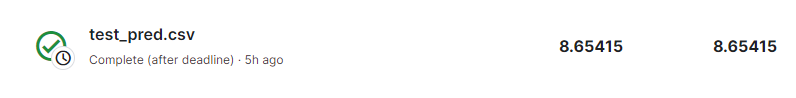

#### Describe and compare the methods you have tried in this project：

剛開始我只堆疊了很多層的捲積層作為我的模型架構，想當然的結果不太理想，連訓練時的結果都不太好，只能下降到0.2左右。

接著我嘗試了助教提醒的resnet18並且也嘗試過resnet50兩個效果在我設定epochs=120時都蠻普通的，起初我以為是要調整模型架構，後來查看了loss值的下降狀況，發現其實還是有在非常緩慢的下降，所以將epochs調高。

不過這時候score卡在了10分左右，想起來學長也有分享過可以嘗試使用schedule方法，我將我的schedule設定為，當我損失值在5個epoch內沒有繼續下降則將學習率下降為原本的95%，這時候終於跨過了base_line70的線，但是也來不及了。

最後的最後我正在嘗試將藍色與白色增強來強化車牌的顯示，不過還在訓練，雖然這樣的模型可能無法正確框選藍色車體的車牌，但我很期待會跑出什麼樣的結果。

#### Overlay training losses and validation losses in the same figure against each epoch.

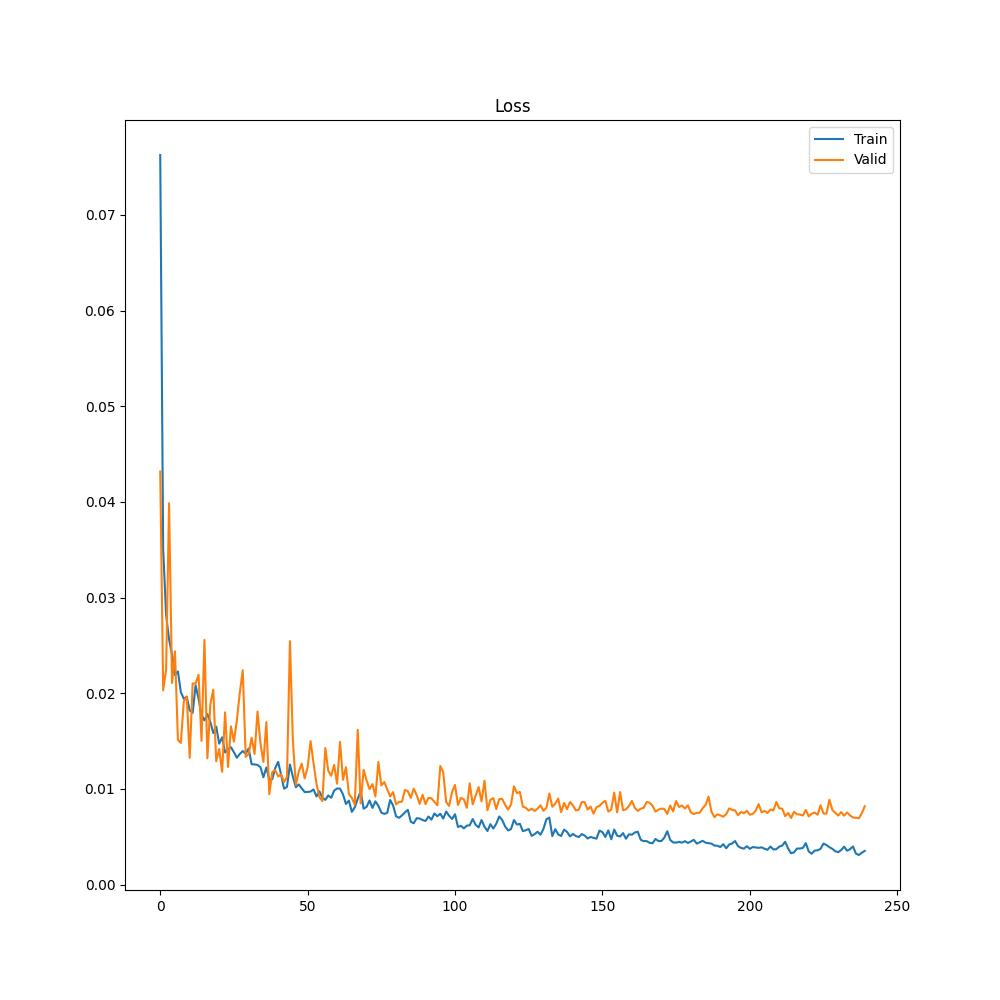

#### Visualization results of my final model on：(1)0000.jpg, (2)1000.jpg

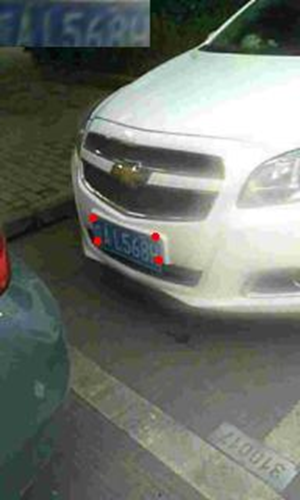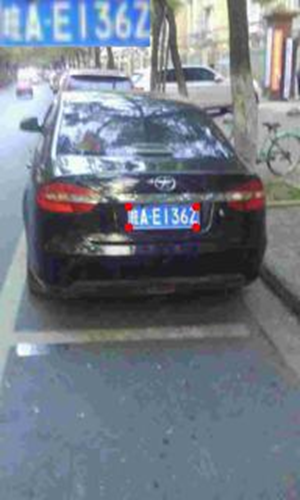